# Clustering via XAI

This notebook takes a kmeans-clustering algorithm and rewrites it as a 2-layer Neural Net, following Kauffmann et al. 2021 (https://arxiv.org/abs/1906.07633). Then, one can use XAI-techniques to analyse the NN. Kauffmann et al. propose Layer-Relevance-Propagation LRP (which will be implemented at a later stage in this notebook).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import *

In [2]:
x = np.random.normal(0,1,100).reshape(-1,1)
y = np.random.normal(0,1,100).reshape(-1,1)
z = np.random.normal(0,1,100).reshape(-1,1)
Data = np.concatenate((x,y,z), axis=1)

x = np.random.normal(0,1,100).reshape(-1,1)
y = np.random.normal(5,1,100).reshape(-1,1)
z = np.random.normal(0,1,100).reshape(-1,1)
newDat = np.concatenate((x,y,z), axis=1)
Data = np.concatenate((Data,newDat))

x = np.random.normal(5,1,100).reshape(-1,1)
y = np.random.normal(-5,1,100).reshape(-1,1)
z = np.random.normal(0,1,100).reshape(-1,1)
newDat = np.concatenate((x,y,z), axis=1)
Data = np.concatenate((Data,newDat))

x = np.random.normal(0,1,100).reshape(-1,1)
y = np.random.normal(0,1,100).reshape(-1,1)
z = np.random.normal(5,1,100).reshape(-1,1)
newDat = np.concatenate((x,y,z), axis=1)
Data = np.concatenate((Data,newDat))

s1 = np.random.normal(0,1,400).reshape(-1,1) # superfluous data
s2 = np.random.normal(0,1,400).reshape(-1,1) # superfluous data

Data = np.concatenate((Data, s1,s2), axis =1)
np.random.shuffle(Data)
print(Data.shape)

(400, 5)


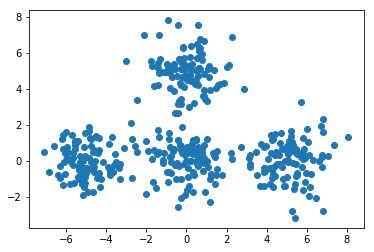

In [3]:
plt.scatter(Data[:,1], Data[:,2])

In [4]:
nKM = 4
kmeans = KMeans(n_clusters=nKM, random_state=0).fit(Data)
print(kmeans.cluster_centers_)
print(kmeans.labels_)

[[ 3.27298488e-02  5.08835026e+00 -2.92112276e-04  8.57941668e-02
   6.55419439e-02]
 [ 5.01246823e+00 -4.93370246e+00 -6.85192730e-03 -8.04469351e-02
  -1.23671898e-01]
 [ 6.25576145e-02  1.24365072e-02 -1.21591317e-02 -2.40590999e-01
  -8.80993839e-02]
 [-1.32642936e-01  4.59282931e-02  4.96047450e+00  2.85538380e-01
  -6.15102806e-03]]
[1 3 0 3 1 3 2 1 1 1 3 1 2 3 2 0 3 2 2 1 1 0 0 2 2 2 0 2 3 0 3 2 1 0 3 0 1
 3 3 1 1 3 0 3 3 1 2 2 2 2 3 3 0 1 3 3 1 2 1 2 2 1 0 2 1 3 1 0 2 3 1 0 1 1
 2 2 0 1 2 3 0 2 1 2 0 2 2 0 1 3 0 1 0 3 0 2 1 0 0 2 0 2 3 1 1 0 2 2 3 2 1
 1 0 2 3 2 1 3 3 2 2 3 0 2 3 1 2 0 3 3 3 2 0 3 0 2 0 1 2 0 0 2 1 1 2 1 2 3
 3 2 2 2 1 2 1 2 1 3 1 3 3 3 2 2 2 3 2 3 2 2 1 3 0 0 1 3 3 3 0 3 0 1 3 3 2
 3 0 0 0 3 3 3 0 3 1 3 3 3 3 0 0 1 0 0 3 2 3 0 3 1 2 1 3 3 1 0 1 0 3 1 2 1
 0 3 2 3 0 0 1 1 1 2 2 2 0 0 0 3 1 1 0 1 3 0 0 2 2 0 2 0 1 3 0 1 1 3 2 2 0
 2 3 3 2 1 3 3 0 0 1 0 0 0 0 3 0 0 1 0 3 0 3 1 1 0 3 2 0 3 0 2 3 3 1 3 1 2
 3 1 3 1 1 0 1 2 1 2 0 2 2 1 2 2 2 3 1 2 0 0 0 1 1 2 1 2 0 

## Neuralising K-Means

We neuralise the clustering classifier with respect to class 0, i.e. write a net that should tell us whether an instance belongs to class 0 or not.

In [5]:
def layer1(x, centroids, i):
    # takes one instance x, centroid-matrix and index of ith centroid
    # returns values for the distances to centroid i
    mu_c = centroids[i]
    w = 2*(mu_c - centroids)
    b = (centroids**2.).sum(1) - (mu_c**2.).sum()
    h = w.dot(x) + b
    return(h)
x = np.ones(Data.shape[1])
layer1(x, kmeans.cluster_centers_, 0)
    

array([  0.        ,  34.39269321, -14.75821562,  -0.95850148])

In [6]:
def layer2(h):
    return(min(h) >= 0)

for i in range(nKM):
    print(layer2(layer1(x, 
                   kmeans.cluster_centers_,
                   i)))

False
False
True
False


In [7]:
def layer2(h,i):
    # i is the index of the cluster which we "test" here
    Indices = np.arange(len(h))
    return(min(h[Indices!=i]) )

def DecisionLayer(Minimum):
    return(Minimum > 0)


for i in range(nKM):
    print(DecisionLayer(layer2(layer1(x, 
                   kmeans.cluster_centers_,
                   i),i)))

False
False
True
False


### Testing this 2-Layer-NN

In [8]:
X = np.random.multivariate_normal(np.ones(Data.shape[1])*2.5, 
                              np.eye(Data.shape[1]), 
                              size=1000)
Cluster_Pred = kmeans.predict(X)

In [9]:
# Now predict via the layers
Layer_Pred = np.empty(1000)



for i in range(1000):
    for j in range(nKM):
        Decision = DecisionLayer(layer2(layer1(X[i,:],
                                               kmeans.cluster_centers_,
                                               j),
                                        j))
        if Decision:
            Layer_Pred[i] = range(nKM)[j]


In [10]:
sum(Layer_Pred != Cluster_Pred)
# Very good! The numerics don't introduce any unexpected errors!

0

## Layer Relevance Propagation


In [11]:


def NN_k(x,centroids,k):
    # checks if x belongs to kth cluster
    return(layer2(layer1(x,centroids,k),k))

In [12]:
Is0 = np.empty(Data.shape[0]) # Output-array whether jth instance is assigned to cluster 0
for i in range(len(Is0)):
    Is0[i] = DecisionLayer(NN_k(Data[i,:], 
                                kmeans.cluster_centers_, 
                                0))


In [13]:
print("Should all be 0:", kmeans.labels_[Is0 == 1])
print("Should all be nonzero:",kmeans.labels_[Is0 != 1])
# Good!

Should all be 0: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Should all be nonzero: [1 3 3 1 3 2 1 1 1 3 1 2 3 2 3 2 2 1 1 2 2 2 2 3 3 2 1 3 1 3 3 1 1 3 3 3 1
 2 2 2 2 3 3 1 3 3 1 2 1 2 2 1 2 1 3 1 2 3 1 1 1 2 2 1 2 3 2 1 2 2 2 1 3 1
 3 2 1 2 2 3 1 1 2 2 3 2 1 1 2 3 2 1 3 3 2 2 3 2 3 1 2 3 3 3 2 3 2 1 2 2 1
 1 2 1 2 3 3 2 2 2 1 2 1 2 1 3 1 3 3 3 2 2 2 3 2 3 2 2 1 3 1 3 3 3 3 1 3 3
 2 3 3 3 3 3 1 3 3 3 3 1 3 2 3 3 1 2 1 3 3 1 1 3 1 2 1 3 2 3 1 1 1 2 2 2 3
 1 1 1 3 2 2 2 1 3 1 1 3 2 2 2 3 3 2 1 3 3 1 3 1 3 3 1 1 3 2 3 2 3 3 1 3 1
 2 3 1 3 1 1 1 2 1 2 2 2 1 2 2 2 3 1 2 1 1 2 1 2 2 2 1 2 3 2 2 2 3 2 3 3 1
 1 2 1 1 1 1 3 3 1 3 1 1 1 1 1 3 3 1 3 1 2 1 1 1 2 3 1 2 3 2 2 3 1 2 3 1 2
 1 3 2 2]


In [14]:
# Beta-Heuristic from eq. (3)

Beta = np.mean(Is0)**(-1.)
print(Beta)

4.0


In [28]:
## IMPLEMENT EQUATION (2)


#For one particular data point x
x = np.zeros(Data.shape[1])
x[0] = 4.5
x[1] = -2.


print(x) 
x_Pred = kmeans.predict(x.reshape(1, -1))[0]
print(x_Pred)

# Let's see why x was assigned to x_Pred:
n_Clust = kmeans.cluster_centers_.shape[0] # number of clusters
h_k = layer1(x, kmeans.cluster_centers_,x_Pred)
f_c = layer2(layer1(x,
                    kmeans.cluster_centers_, x_Pred), x_Pred)
print(f_c)

# numerator of equation (2)
r_k = np.exp(-Beta * h_k) *f_c
print(r_k)
print(r_k[range(n_Clust) != x_Pred])

R_k = r_k/ sum(r_k[range(n_Clust) != x_Pred])
print("R_k",R_k) # Equation (2)

[ 4.5 -2.   0.   0.   0. ]
1
14.915541779713685
[4.43327362e-106 1.49155418e+001 1.83100308e-025 1.50653522e-071]
[4.43327362e-106 1.83100308e-025 1.50653522e-071]
R_k [2.42122674e-81 8.14610415e+25 1.00000000e+00 8.22792292e-47]


In [29]:
# IMPLEMENT EQUATION (4)
m_k = 0.5*(kmeans.cluster_centers_ + kmeans.cluster_centers_[x_Pred])
print(m_k)
Diff_x_m = x - m_k
print(Diff_x_m.shape)
print(" # # # # ")
Diff_x_m_reduced = Diff_x_m[range(n_Clust) != x_Pred]
print(Diff_x_m_reduced.shape)

[[ 2.52259904e+00  7.73239015e-02 -3.57201979e-03  2.67361586e-03
  -2.90649771e-02]
 [ 5.01246823e+00 -4.93370246e+00 -6.85192730e-03 -8.04469351e-02
  -1.23671898e-01]
 [ 2.53751292e+00 -2.46063298e+00 -9.50552951e-03 -1.60518967e-01
  -1.05885641e-01]
 [ 2.43991265e+00 -2.44388708e+00  2.47681129e+00  1.02545722e-01
  -6.49114631e-02]]
(4, 5)
 # # # # 
(3, 5)


In [30]:
mu_c = kmeans.cluster_centers_[x_Pred]
W = 2*(mu_c - kmeans.cluster_centers_)
W_reduced = W[range(n_Clust) != x_Pred]
W_reduced.shape

R_previous_reduced = R_k[range(n_Clust)!= x_Pred] # from Equation (2)
print(R_previous_reduced)

[2.42122674e-81 1.00000000e+00 8.22792292e-47]


In [31]:
Product = np.multiply(Diff_x_m_reduced, W_reduced)
print(Product)
# Product is a Matrix P_ki with k = number of Clusters -1
#                               i = Index of the input feature
#       Shape of Product is (number Clusters -1,  number Input Features)

print(Product.shape)
print(Product[:,1])

[[ 1.96938789e+01  4.16380993e+01 -4.68635781e-05  8.88929694e-04
  -1.09989920e-02]
 [ 1.94282712e+01 -4.55670944e+00  1.00895577e-04  5.14123192e-02
  -7.53323693e-03]
 [ 2.11987569e+01 -4.42078755e+00  2.46062603e+01  7.50604569e-02
  -1.52569032e-02]]
(3, 5)
[41.63809934 -4.55670944 -4.42078755]


In [32]:
R_input = np.empty(Data.shape[1]) # Relevance of each input-feature

Denominator_Eq4 = np.sum(Product,1) # summing over all input features
print(Denominator_Eq4)

[61.32182133 14.91554178 41.44403322]


In [33]:
for k in range(3):
    print(np.sum(Product[k,:]))

61.321821330502424
14.915541779713687
41.444033221414074


In [34]:

for i in range(len(R_input)):
    
    for k in range(n_Clust-1):
        
        R_input[i] +=  Product[k,i] * R_previous_reduced[k] / np.sum(Product[k,:])
    
print(R_input.round(1))

[26.4 24.   0.   0.   0. ]


In [35]:
print(x, x_Pred)
print(kmeans.cluster_centers_.round(1))

[ 4.5 -2.   0.   0.   0. ] 1
[[ 0.   5.1 -0.   0.1  0.1]
 [ 5.  -4.9 -0.  -0.1 -0.1]
 [ 0.1  0.  -0.  -0.2 -0.1]
 [-0.1  0.   5.   0.3 -0. ]]


#### Now for a different example

In [37]:
x = np.zeros(Data.shape[1])
x[1] = 4.0
x[2] = 2.0
x[3] = 1.0

In [38]:

x_Pred = kmeans.predict(x.reshape(1, -1))[0]
print(x_Pred)

## IMPLEMENT EQUATION (2)

# Let's see why x was assigned to x_Pred:
n_Clust = kmeans.cluster_centers_.shape[0] # number of clusters
h_k = layer1(x, kmeans.cluster_centers_,x_Pred)
f_c = layer2(layer1(x,
                    kmeans.cluster_centers_, x_Pred), x_Pred)
print(f_c)

# numerator of equation (2)
r_k = np.exp(-Beta * h_k) *f_c
print(r_k)
print(r_k[range(n_Clust) != x_Pred])

R_k = r_k/ sum(r_k[range(n_Clust) != x_Pred])
print("R_k",R_k) # Equation (2)


# IMPLEMENT EQUATION (4)
m_k = 0.5*(kmeans.cluster_centers_ + kmeans.cluster_centers_[x_Pred])
print(m_k)
Diff_x_m = x - m_k
print(Diff_x_m.shape)
print(" # # # # ")
Diff_x_m_reduced = Diff_x_m[range(n_Clust) != x_Pred]
print(Diff_x_m_reduced.shape)

mu_c = kmeans.cluster_centers_[x_Pred]
W = 2*(mu_c - kmeans.cluster_centers_)
W_reduced = W[range(n_Clust) != x_Pred]
W_reduced.shape

R_previous_reduced = R_k[range(n_Clust)!= x_Pred] # from Equation (2)
print(R_previous_reduced)

Product = np.multiply(Diff_x_m_reduced, W_reduced)
print(Product)
# Product is a Matrix P_ki with k = number of Clusters -1
#                               i = Index of the input feature
#       Shape of Product is (number Clusters -1,  number Input Features)

print(Product.shape)
print(Product[:,1])

R_input = np.empty(Data.shape[1]) # Relevance of each input-feature

Denominator_Eq4 = np.sum(Product,1) # summing over all input features
print(Denominator_Eq4)

0
15.47337383542678
[1.54733738e+001 2.07036388e-180 2.03977153e-026 2.27136572e-032]
[2.07036388e-180 2.03977153e-026 2.27136572e-032]
R_k [7.58582831e+026 1.01499680e-154 9.99998886e-001 1.11353804e-006]
[[ 3.27298488e-02  5.08835026e+00 -2.92112276e-04  8.57941668e-02
   6.55419439e-02]
 [ 2.52259904e+00  7.73239015e-02 -3.57201979e-03  2.67361586e-03
  -2.90649771e-02]
 [ 4.76437316e-02  2.55039339e+00 -6.22562200e-03 -7.73984159e-02
  -1.12787200e-02]
 [-4.99565434e-02  2.56713928e+00  2.48009119e+00  1.85666273e-01
   2.96954579e-02]]
(4, 5)
 # # # # 
(3, 5)
[1.01499680e-154 9.99998886e-001 1.11353804e-006]
[[ 2.51237665e+01  7.86265334e+01  2.62861237e-02  3.31593274e-01
   1.09989920e-02]
 [ 2.84221213e-03  1.47161563e+01  4.76158370e-02  7.03293720e-01
   3.46575503e-03]
 [ 1.65229053e-02  1.44501768e+01  4.76324074e+00 -3.25316899e-01
  -4.25791126e-03]]
(3, 5)
[78.62653337 14.71615631 14.45017676]
[104.11917827  15.47337384  18.9003656 ]


In [39]:

for i in range(len(R_input)):
    
    for k in range(n_Clust-1):
        
        R_input[i] +=  Product[k,i] * R_previous_reduced[k] / np.sum(Product[k,:])
    
print(R_input.round(1))

[ 0.  26.8  0.   0.1  0. ]


In [40]:
print(x, x_Pred)
print(kmeans.cluster_centers_.round(1))

[0. 4. 2. 1. 0.] 0
[[ 0.   5.1 -0.   0.1  0.1]
 [ 5.  -4.9 -0.  -0.1 -0.1]
 [ 0.1  0.  -0.  -0.2 -0.1]
 [-0.1  0.   5.   0.3 -0. ]]
